# Initialise

## Imports

In [26]:
# Sci-kit Learn imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline


# Other Python library imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use('ggplot')


#### MY CUSTOM functions (defined in custom_functions.py for modularity)
from custom_functions import save_submission_file, save_model_config, load_model_config, get_model_names, get_pipeline, extract_pipeline_config, best_model, CONFIG_FILE, MY_SEED, get_training_splits, STEP_CLASS_MAP


## Data Loadings

In [27]:
train_data_file = '../data/processed/train_feature_clean.csv'
test_data_file = '../data/processed/test_feature_clean.csv'

df_train = pd.read_csv(train_data_file)
df_test = pd.read_csv(test_data_file)

features = df_train.columns[3:]

X_train = df_train[features].values
y_train = df_train['activity']

X_test = df_test[features].values

# Training

Architecture of a *Random Forest Classifier*.

## Building The Model

I've given myself two options here. Either:

### A. Manually specify Pipeline & Parameters

In [ ]:
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=None),
    RandomForestClassifier(
        random_state=MY_SEED,
        n_estimators=100,
        n_jobs = -1,
        )
)

or

### B. Load from config file

In [82]:
model_names = get_model_names(CONFIG_FILE)
[print(m) for m in model_names]

model_0
model_1
model_2
model_3
model_4
model_5


[None, None, None, None, None, None]

In [3]:
# model_name = best_model()
model_name = 'model_1.1.2'
model  = load_model_config(model_name)

# Validating the Model

With a baseline model (loaded above), I proceed to produce the next model with experiments.

**NOTE**: not all experiments below were used for every model; iteratively, the process is developed & newer models are subjected to newer experimentation.

## Cross-Validation Settings

For new model-iterations, we need to test their generalizing performance. Without test-data, we can split our usage of training-data to achieve this:
1. *Split* the training-data into $k$ subsets ("folds")
2. Train on $(k-1)$ folds, use 1 fold for testing performance.
3. Complete this with each $k$-fold being used once as validation-fold.

`RandomForestClassifer` method has an argument for weighting predictions according to class-distributions, so for the most part, specifying class-distributions within k-folds is not performed. However, I also experiment with using the `StratifiedKFold` method, which aims to produce folds with class-distribution like in 

In [35]:
k_splits = 5
stratified_cv = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=MY_SEED)
scoring_method = 'f1_macro'

## Initial Validation

In [40]:
cv_results = cross_validate(pipeline, X_train, y_train, cv=stratified_cv, scoring=['accuracy', 'f1_macro'], return_train_score=False)

print(f"Cross-validation Accuracy: {cv_results['test_accuracy']}")
print(f"Cross-validation F1 scores: {cv_results['test_f1_macro']}")
print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy'])}")
print(f"Mean F1 score: {np.mean(cv_results['test_f1_macro'])}")

Cross-validation Accuracy: [0.95496894 0.97593168 0.97282609 0.97282609 0.97125097]
Cross-validation F1 scores: [0.94140788 0.97274103 0.96677648 0.96399088 0.96187103]
Mean Accuracy: 0.9695607532564054
Mean F1 score: 0.9613574574712693


# Experimenting

This section contains the various methods of experimentation that I used to iteratively improve upon the model.

## Parameter Sets
Setting up different parameter settings in dictionaries, for the search-method to optimize within.

In [12]:
model1_param_grid = {
    'pca__n_components': [10, 20, 30, 40, None],
    'randomforestclassifier__n_estimators': [100, 200, 400, 600],
    'randomforestclassifier__max_depth': [None, 10, 20]
}

model2_param_grid = {
    'pca__n_components': [10, 20, 30, 40, None],
    'randomforestclassifier__criterion': ['entropy', 'gini', 'log_loss'],
    'randomforestclassifier__n_estimators': [100, 200, 400, 600],
    'randomforestclassifier__max_depth': [None, 10, 20, 30, 40]
}

model3_param_grid = {
    'pca__n_components': np.arange(10, 49, 1),
    'randomforestclassifier__n_estimators': np.arange(100, 1000, 50),
    'randomforestclassifier__max_depth': np.arange(10, 50, 5)
}
total_samples = len(df_train)

param_grid_4 = {
    'randomforestclassifier__max_features': np.linspace(0.1, 1, 5),
    'randomforestclassifier__max_leaf_nodes': np.linspace(100, total_samples, 10).astype(int)
}


## Parameter Search

### Grid Search

In [13]:
param_search = GridSearchCV(estimator = pipeline,
                         param_grid=param_grid_4,
                         cv = k_splits, 
                         scoring = scoring_method,
                         n_jobs=-1)

param_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=6))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_features': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                         'randomforestclassifier__max_leaf_nodes': array([ 100,  804, 1508, 2213, 2917, 3621, 4326, 5030, 5734, 6439])},
             scoring='f1_macro')

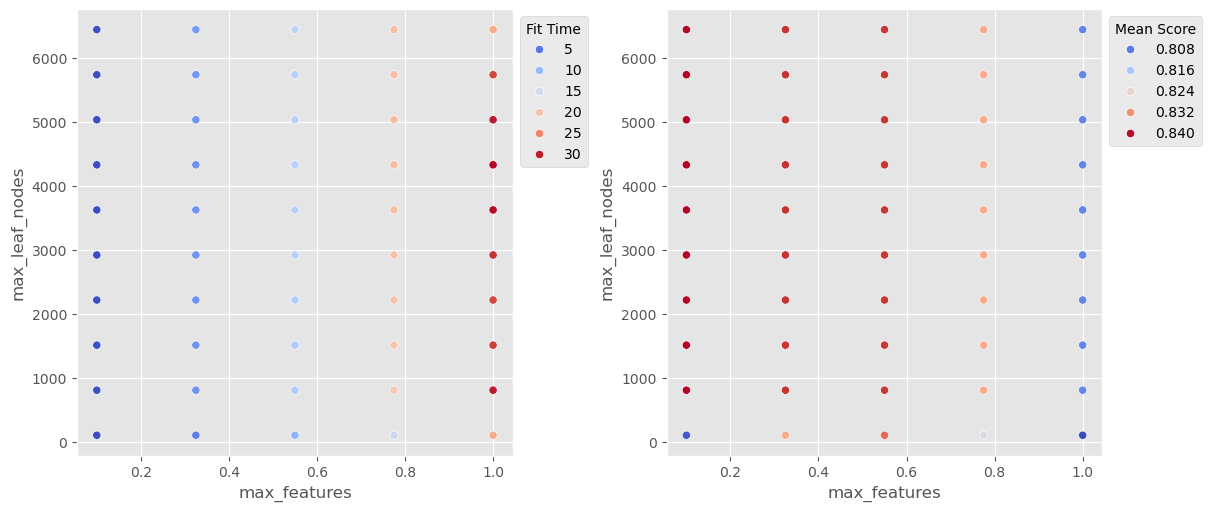

In [22]:
fit_times = param_search.cv_results_['mean_fit_time']
max_features = param_search.cv_results_['param_randomforestclassifier__max_features']
leaf_nodes = param_search.cv_results_['param_randomforestclassifier__max_leaf_nodes']
mean_scores = param_search.cv_results_['mean_test_score']

palette = 'coolwarm'

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5), layout = 'constrained')
axs.ravel()

for ax, hue, label in zip(axs, [fit_times, mean_scores], ['Fit Time', 'Mean Score']):
    sns.scatterplot(x = max_features, y = leaf_nodes, hue = hue, ax = ax, palette = palette)
    ax.legend(title = label, bbox_to_anchor = [1, 1])

[ax.set_xlabel('max_features') for ax in axs]
[ax.set_ylabel('max_leaf_nodes') for ax in axs]

# plt.suptitle('Effects of Varying PCA n_components vs. RandomForestClassifier n_estimators')
plt.show()

### Randomized Search

In [12]:
n_iter = 20

param_search = RandomizedSearchCV(estimator = pipeline,
                                   param_distributions=model3_param_grid,
                                   n_iter = n_iter,
                                   scoring = scoring_method,
                                   n_jobs=-1, 
                                   cv = stratified_cv)

param_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=6, shuffle=True),
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('pca', PCA()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     criterion='entropy',
                                                                     max_depth=20,
                                                                     n_estimators=600,
                                                                     n_jobs=-1,
                                                                     random_state=6))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48]),
                                        'randomforestclassifier__max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                                        'randomforestclassifier__n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950])},
                   scoring='f1_macro')

### Best params from Search

In [89]:
[print(f'Best Parameter ({k}) = {v}') for k, v in param_search.best_params_.items()]

Best Parameter (randomforestclassifier__max_features) = 0.1
Best Parameter (randomforestclassifier__max_leaf_nodes) = 804


[None, None]

### Visualising param_search results

<Axes: >

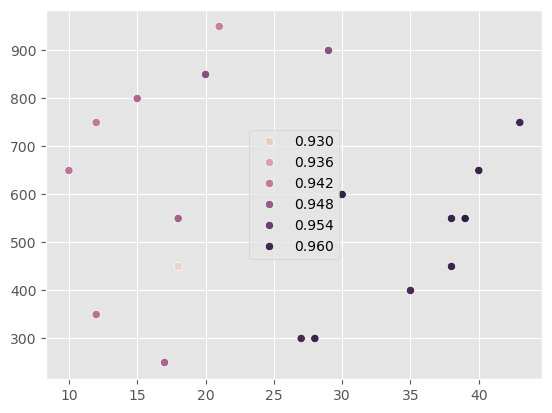

In [ ]:
fit_times = param_search.cv_results_['mean_fit_time']
n_estimators = param_search.cv_results_['param_randomforestclassifier__n_estimators']
n_components = param_search.cv_results_['param_pca__n_components']
max_depth = param_search.cv_results_['param_randomforestclassifier__max_depth']
mean_scores = param_search.cv_results_['mean_test_score']

sns.scatterplot(x = n_components, y = n_estimators, hue = mean_scores)

## Experiment 1: Varying PCA components vs. N_estimators
The below demonstrates effects of varying number-of-PCA-components kept, and number-of-trees in the Random Forest model, with the related fit-times & mean-scores.

It's clear that 

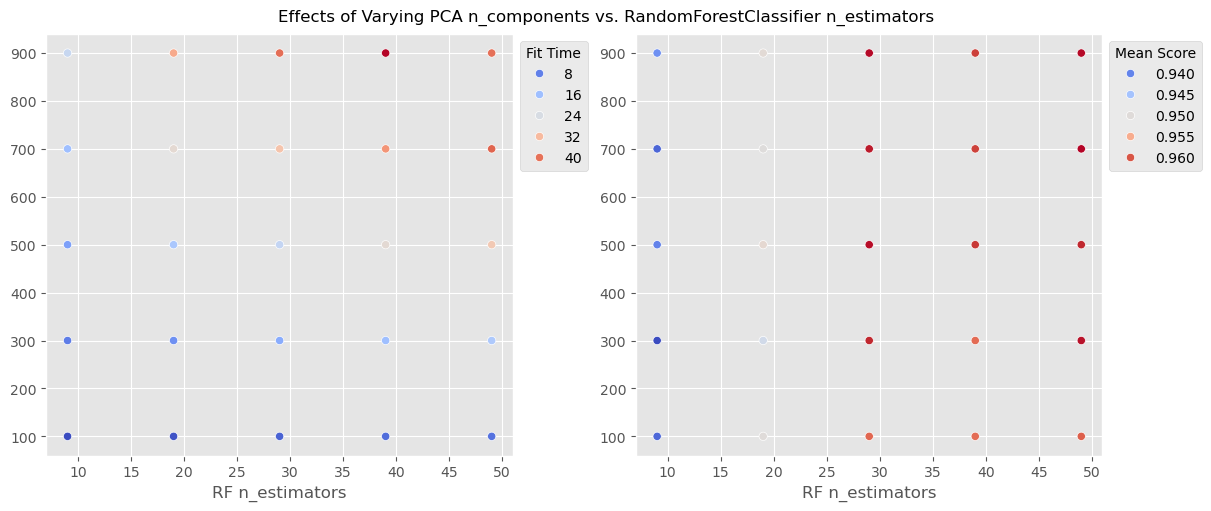

In [46]:
effect_of_pca_and_treecount = {
    'pca__n_components': np.arange(9, 50, 10),
    'randomforestclassifier__n_estimators': np.arange(100, 1100, 200),
}

effect_of_pca_and_treecount_search = GridSearchCV(estimator = pipeline,
                         param_grid=effect_of_pca_and_treecount,
                         cv = stratified_cv, 
                         scoring = scoring_method,
                         n_jobs=-1)

effect_of_pca_and_treecount_search.fit(X_train, y_train)

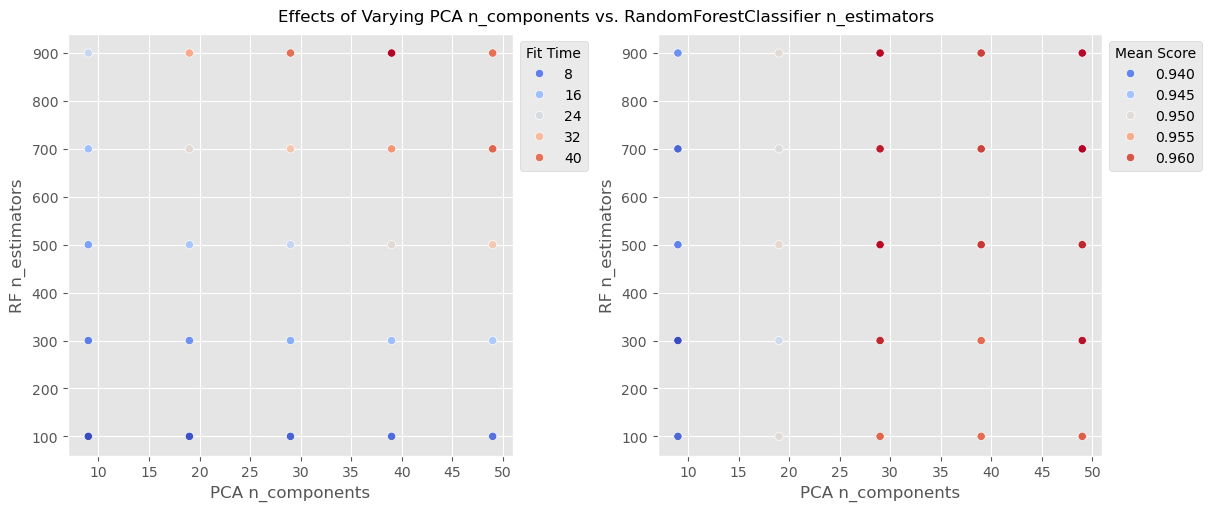

In [48]:
fit_times = effect_of_pca_and_treecount_search.cv_results_['mean_fit_time']
n_estimators = effect_of_pca_and_treecount_search.cv_results_['param_randomforestclassifier__n_estimators']
n_components = effect_of_pca_and_treecount_search.cv_results_['param_pca__n_components']
mean_scores = effect_of_pca_and_treecount_search.cv_results_['mean_test_score']

palette = 'coolwarm'

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5), layout = 'constrained')
axs.ravel()

for ax, hue, label in zip(axs, [fit_times, mean_scores], ['Fit Time', 'Mean Score']):
    sns.scatterplot(x = n_components, y = n_estimators, hue = hue, ax = ax, palette = palette)
    ax.legend(title = label, bbox_to_anchor = [1, 1])

[ax.set_xlabel('PCA n_components') for ax in axs]
[ax.set_ylabel('RF n_estimators') for ax in axs]

plt.suptitle('Effects of Varying PCA n_components vs. RandomForestClassifier n_estimators')
plt.show()

## Experiment 2: Varying max_depth
Another experiment to investigate effects of changing `max_depth`.

Here, we see broadly that increasing depth has the effect of improving performance (at potential cost of overfitting however).

Alternatively, the more modest (n_estimators, max_depth) = (300, 15) has the *highest* mean_score, and are relatively *much faster* to train. Takeaway? better-performing models are much less complex! **Higher Generlizability.**

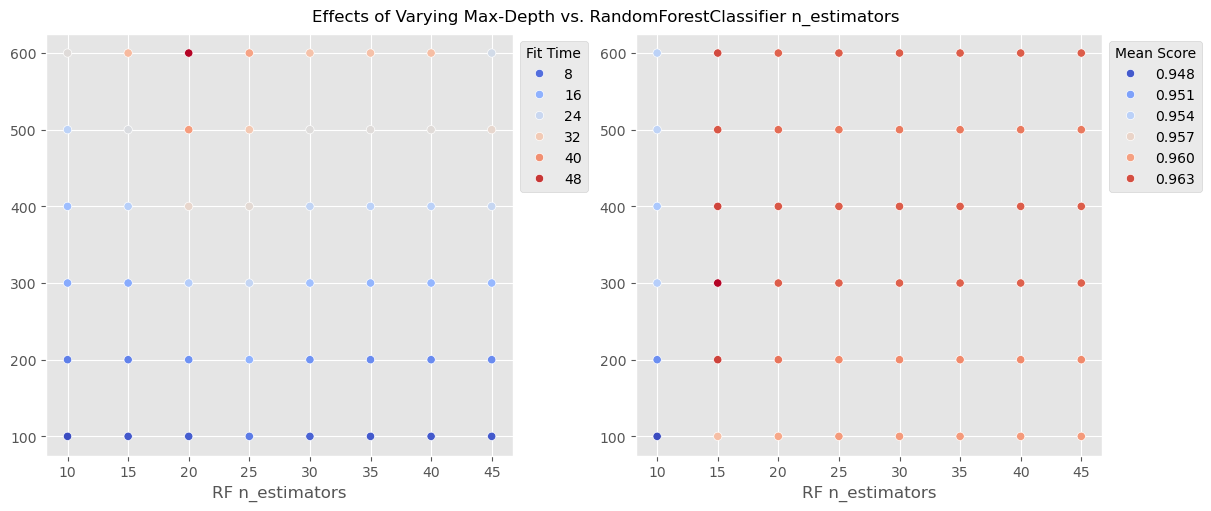

In [ ]:
effect_of_pca_and_maxdepth = {
    'randomforestclassifier__max_depth': np.arange(10, 50, 5),
    'randomforestclassifier__n_estimators': np.arange(100, 601, 100),
}

effect_of_pca_and_maxdepth_search = GridSearchCV(estimator = pipeline,
                         param_grid=effect_of_pca_and_maxdepth,
                         cv = stratified_cv, 
                         scoring = scoring_method,
                         n_jobs=-1)

effect_of_pca_and_maxdepth_search.fit(X_train, y_train)

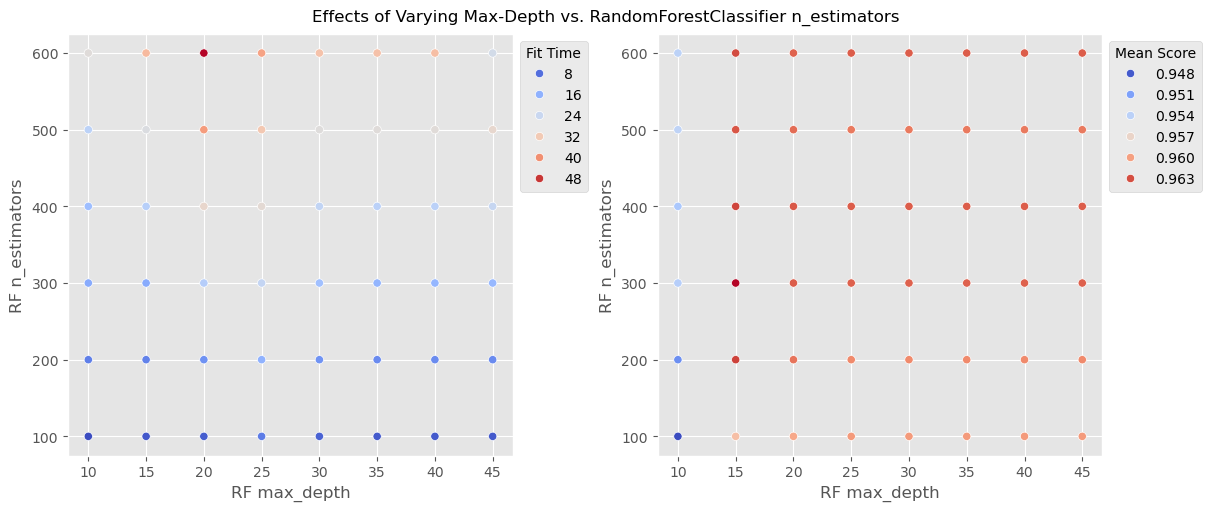

In [ ]:
fit_times = effect_of_pca_and_maxdepth_search.cv_results_['mean_fit_time']
n_estimators = effect_of_pca_and_maxdepth_search.cv_results_['param_randomforestclassifier__n_estimators']
max_depth = effect_of_pca_and_maxdepth_search.cv_results_['param_randomforestclassifier__max_depth']
mean_scores = effect_of_pca_and_maxdepth_search.cv_results_['mean_test_score']

palette = 'coolwarm'

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5), layout = 'constrained')
axs.ravel()

for ax, hue, label in zip(axs, [fit_times, mean_scores], ['Fit Time', 'Mean Score']):
    sns.scatterplot(x = max_depth, y = n_estimators, hue = hue, ax = ax, palette = palette)
    ax.legend(title = label, bbox_to_anchor = [1, 1])

[ax.set_xlabel('RF max_depth') for ax in axs]
[ax.set_ylabel('RF n_estimators') for ax in axs]

plt.suptitle('Effects of Varying Max-Depth vs. RandomForestClassifier n_estimators')
plt.show()

## Visualisations

### Graphviz of Decision Tree

Useful for getting a broad sense for what the individual trees look like.

E.g.  The root-node Decision for this tree has $x[2]$ as its feature (PC2) - Corresponding features are seen in a below plot

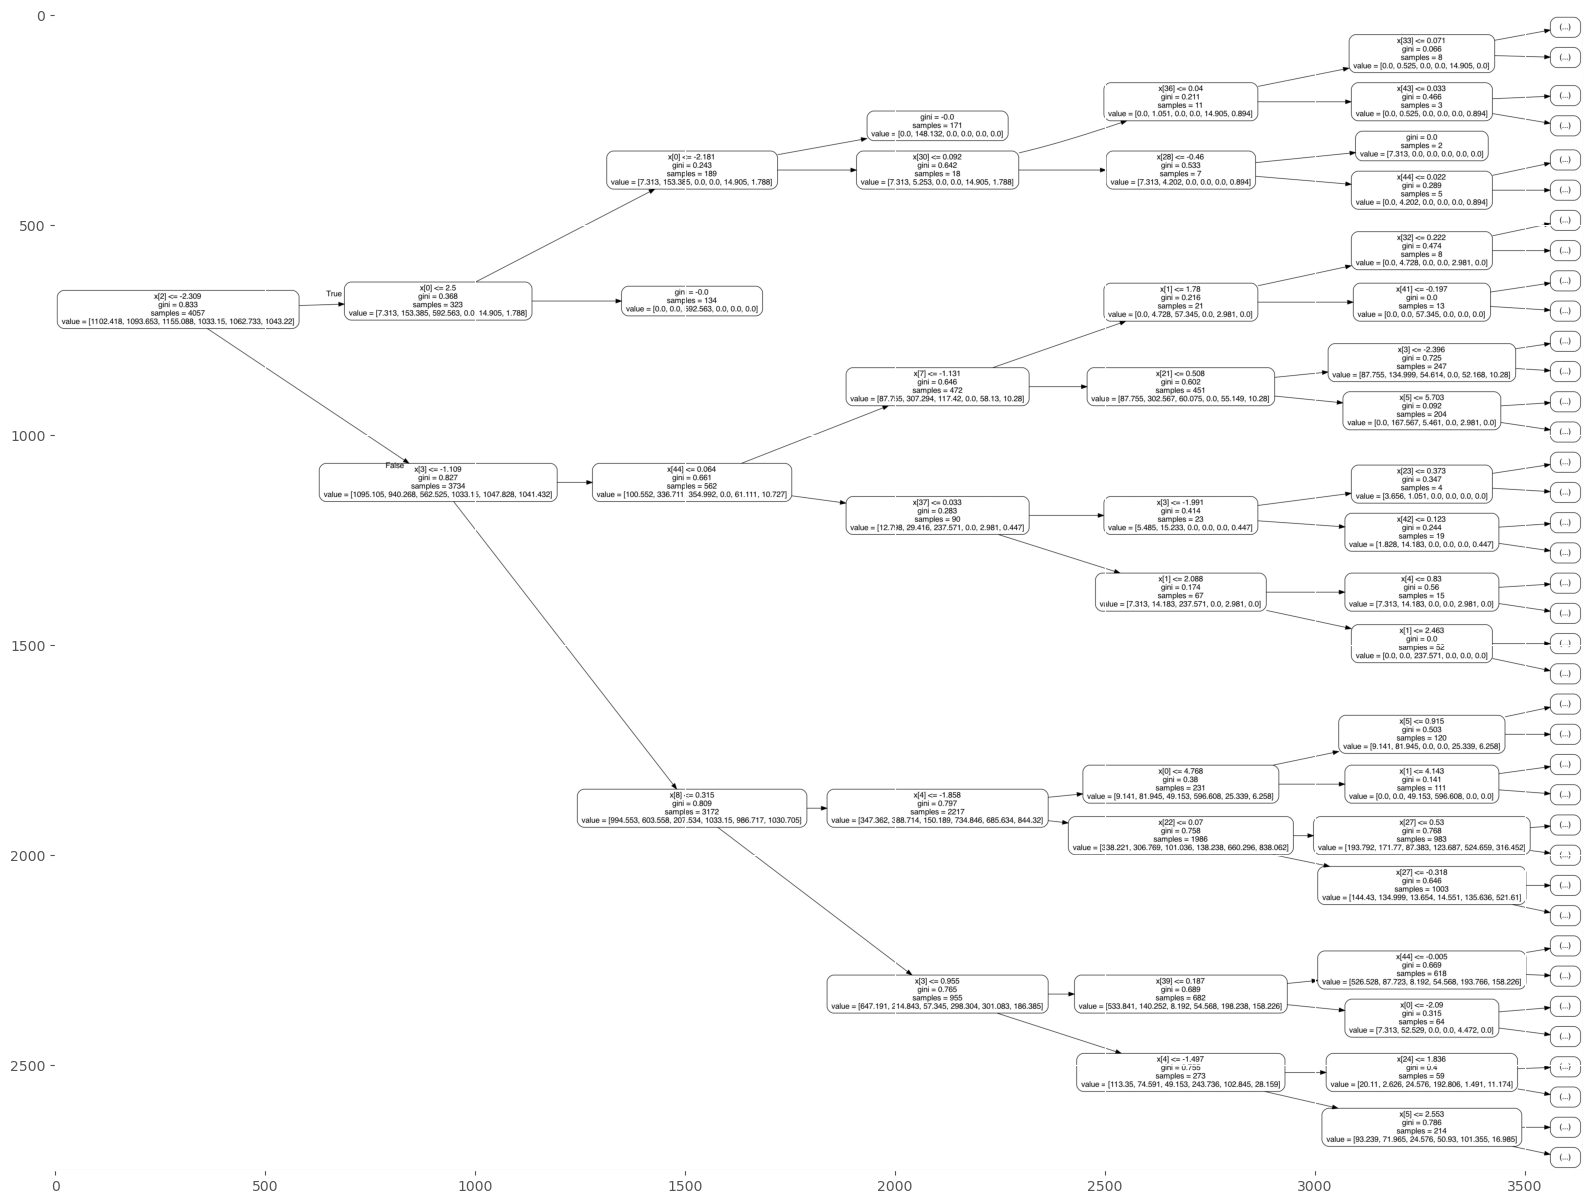

In [100]:
export_graphviz(model.named_steps['randomforestclassifier'].estimators_[0], 'tree.dot', rounded = True, rotate = True, max_depth = 5)
! dot -Tpng tree.dot -o tree.png

fig, ax = plt.subplots(figsize = (50, 15))

ax.imshow(np.asarray(Image.open('tree.png')))
plt.show()

### PCA visualisation

In [112]:
from collections import OrderedDict

# OrderedDict preserves order for plotting
feature_groups = OrderedDict({
    "x_stats":       [f"x_{stat}" for stat in ["mean", "std", "max", "min", "median", "skew", "kurtosis", "mad", "abs_dev"]],
    "y_stats":       [f"y_{stat}" for stat in ["mean", "std", "max", "min", "median", "skew", "kurtosis", "mad", "abs_dev"]],
    "z_stats":       [f"z_{stat}" for stat in ["mean", "std", "max", "min", "median", "skew", "kurtosis", "mad", "abs_dev"]],
    "mag_stats":     ["mag_mean", "mag_std", "mag_energy", "mag_entropy"],
    "x_fft":         [f"x_fft_{stat}" for stat in ["mean", "std", "max", "peak_freq"]],
    "y_fft":         [f"y_fft_{stat}" for stat in ["mean", "std", "max", "peak_freq"]],
    "z_fft":         [f"z_fft_{stat}" for stat in ["mean", "std", "max", "peak_freq"]],
    "correlations":  ["xy_corr", "xz_corr", "yz_corr"],
    "peak_dist":     ["x_peak_dist_mean", "y_peak_dist_mean", "z_peak_dist_mean"]
})


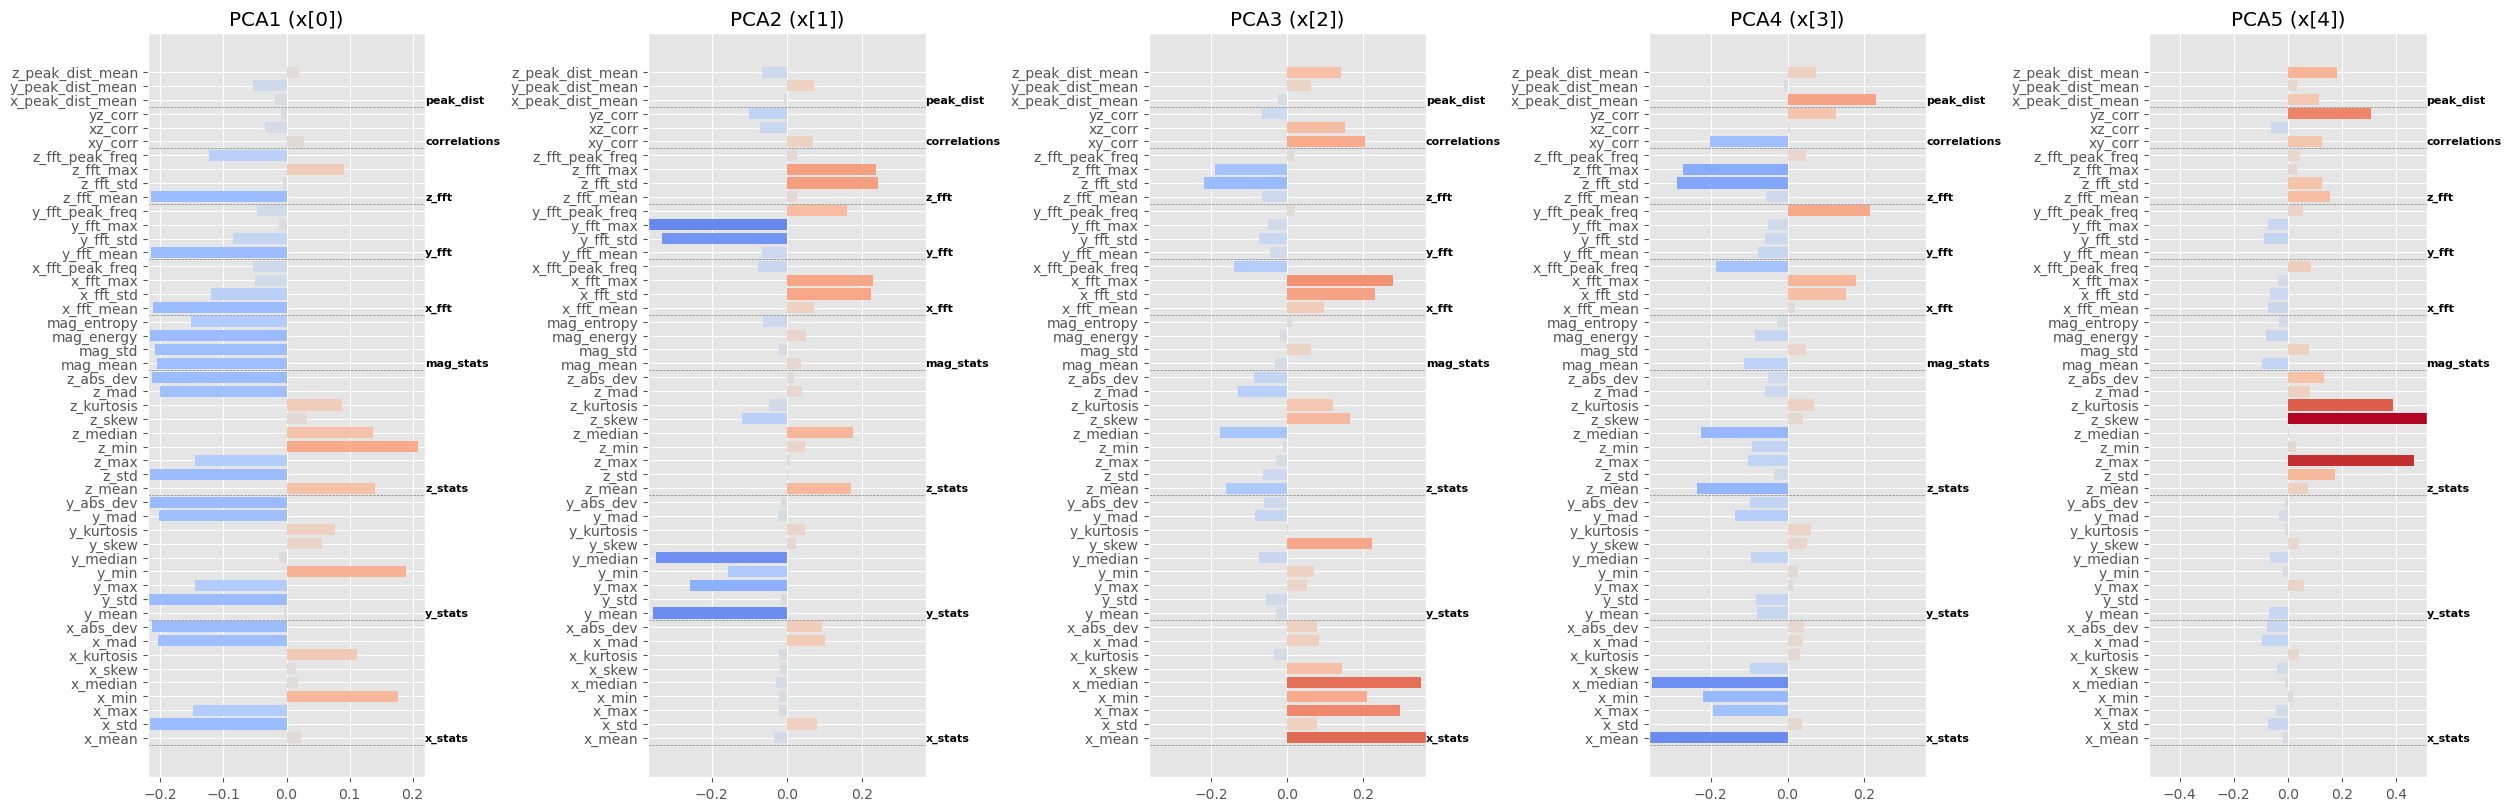

In [ ]:

# OrderedDict preserves order for plotting
feature_groups = OrderedDict({
    "x_stats":       [f"x_{stat}" for stat in ["mean", "std", "max", "min", "median", "skew", "kurtosis", "mad", "abs_dev"]],
    "y_stats":       [f"y_{stat}" for stat in ["mean", "std", "max", "min", "median", "skew", "kurtosis", "mad", "abs_dev"]],
    "z_stats":       [f"z_{stat}" for stat in ["mean", "std", "max", "min", "median", "skew", "kurtosis", "mad", "abs_dev"]],
    "mag_stats":     ["mag_mean", "mag_std", "mag_energy", "mag_entropy"],
    "x_fft":         [f"x_fft_{stat}" for stat in ["mean", "std", "max", "peak_freq"]],
    "y_fft":         [f"y_fft_{stat}" for stat in ["mean", "std", "max", "peak_freq"]],
    "z_fft":         [f"z_fft_{stat}" for stat in ["mean", "std", "max", "peak_freq"]],
    "correlations":  ["xy_corr", "xz_corr", "yz_corr"],
    "peak_dist":     ["x_peak_dist_mean", "y_peak_dist_mean", "z_peak_dist_mean"]
})


pca = model.named_steps['pca']
count_to_show = 5
components = pca.components_[:count_to_show]

abs_max = np.abs(components).max()
norm = Normalize(-abs_max, abs_max)
cmap = cm.coolwarm


group_boundaries = []
flat_features = []
for group in feature_groups.values():
    group_boundaries.append(len(flat_features))
    flat_features.extend(group)

# `flat_features` is your ordered feature list
# `group_boundaries` gives where each group starts (for drawing dividers)
group_names = list(feature_groups.keys())

fig, axs = plt.subplots(ncols=count_to_show, nrows=1, figsize=(count_to_show * 5, 8), layout='constrained')
axs.ravel()
# for i, ax in enumerate(axs):
#     colors = cmap(norm(components[i]))
#     ax.barh(features, components[i], color = colors)
#     ax.set_title(f'PCA{i + 1}')
#     ax.set_xlim(-abs_max, abs_max)
for i, ax in enumerate(axs):
 
    ax.barh(flat_features, components[i], color=cmap(norm(components[i])))
    ax.set_title(f'PCA{i + 1} (x[{i}])')
    ax_max = np.abs(components[i]).max()
    ax.set_xlim(-ax_max, ax_max)
    # ax.set_xlim(-abs_max, abs_max)

    # Draw group dividers
    for boundary in group_boundaries:
        ax.axhline(boundary - 0.5, color='gray', linestyle='--', linewidth=0.5)
    
    # Annotate group labels
    for j, boundary in enumerate(group_boundaries):
        ax.text(ax_max, boundary, group_names[j],
                va='center', ha='left', fontsize=8, fontweight='bold')


### Feature_importance_ across models

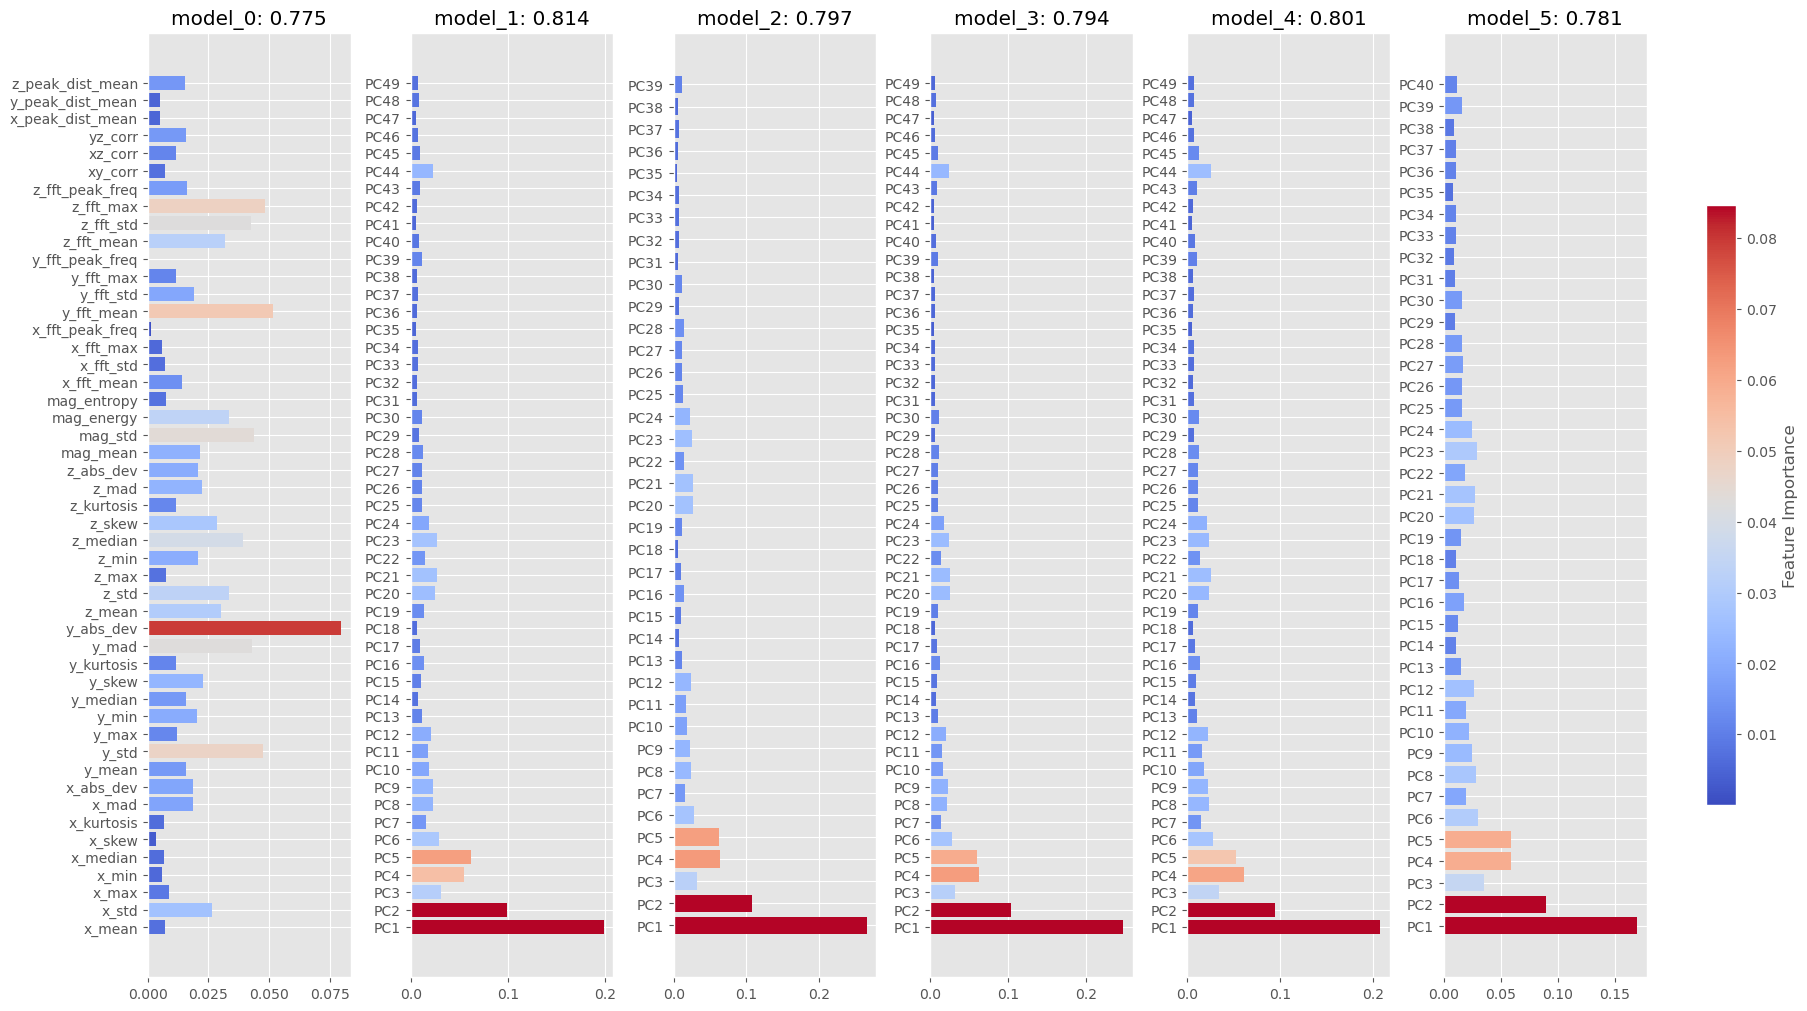

In [ ]:
# First, gather all importances to normalize
all_importances = []
for model_no in range(6):
    model_name = f'model_{model_no}'
    model = load_model_config(model_name)
    pipeline = get_pipeline(model)
    pipeline.fit(X_train, y_train)
    rf = pipeline.named_steps['randomforestclassifier']
    try:
        pca = pipeline.named_steps['pca']
        importances = np.abs(pca.components_.T @ rf.feature_importances_)
    except KeyError:
        importances = rf.feature_importances_
    all_importances.extend(importances)

norm = Normalize(vmin=min(all_importances), vmax=max(all_importances))
cmap = cm.coolwarm

# Plot with consistent coloring
fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(18, 10), layout='constrained')
axs = axs.ravel()
all_importances = {}
for model_no, ax in enumerate(axs):
    model_name = f'model_{model_no}'
    model = load_model_config(model_name)
    score = model['score']
    pipeline = get_pipeline(model)
    pipeline.fit(X_train, y_train)
    rf = pipeline.named_steps['randomforestclassifier']
    
    try:
        pca = pipeline.named_steps['pca']
        # importances = np.abs(pca.components_.T @ rf.feature_importances_)
        importances = rf.feature_importances_
        pca_pres = True
    except KeyError:
        importances = rf.feature_importances_
        pca_pres = False
    all_importances[model_name] = importances
    colors = cmap(norm(importances))
    if pca_pres:
        bars = ax.barh([f'PC{i + 1}' for i in range(len(importances))], importances, color=colors)
    else:
        bars = ax.barh(features, importances, color=colors)
    ax.set_title(f'{model_name}: {score:.3f}')

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label='Feature Importance')
plt.show()

### PC1 Components Across models

Invariably, PC1 is the most important component for models 1-5. Do models build PC1 differently?

**ANSWER**: No. This highest PC corresponds to the eigenvector of $COV(X)$ which has the *highest* eigenvalue - usually, this highest-eigenvalue far exceeds the next-highest eigenvalue, so is unlikely to change under differnet interpretations/random-state settings.

Different PC results will result from the *lower eigenvalues*, those that are highly close & therefore liable to change under different random_states.

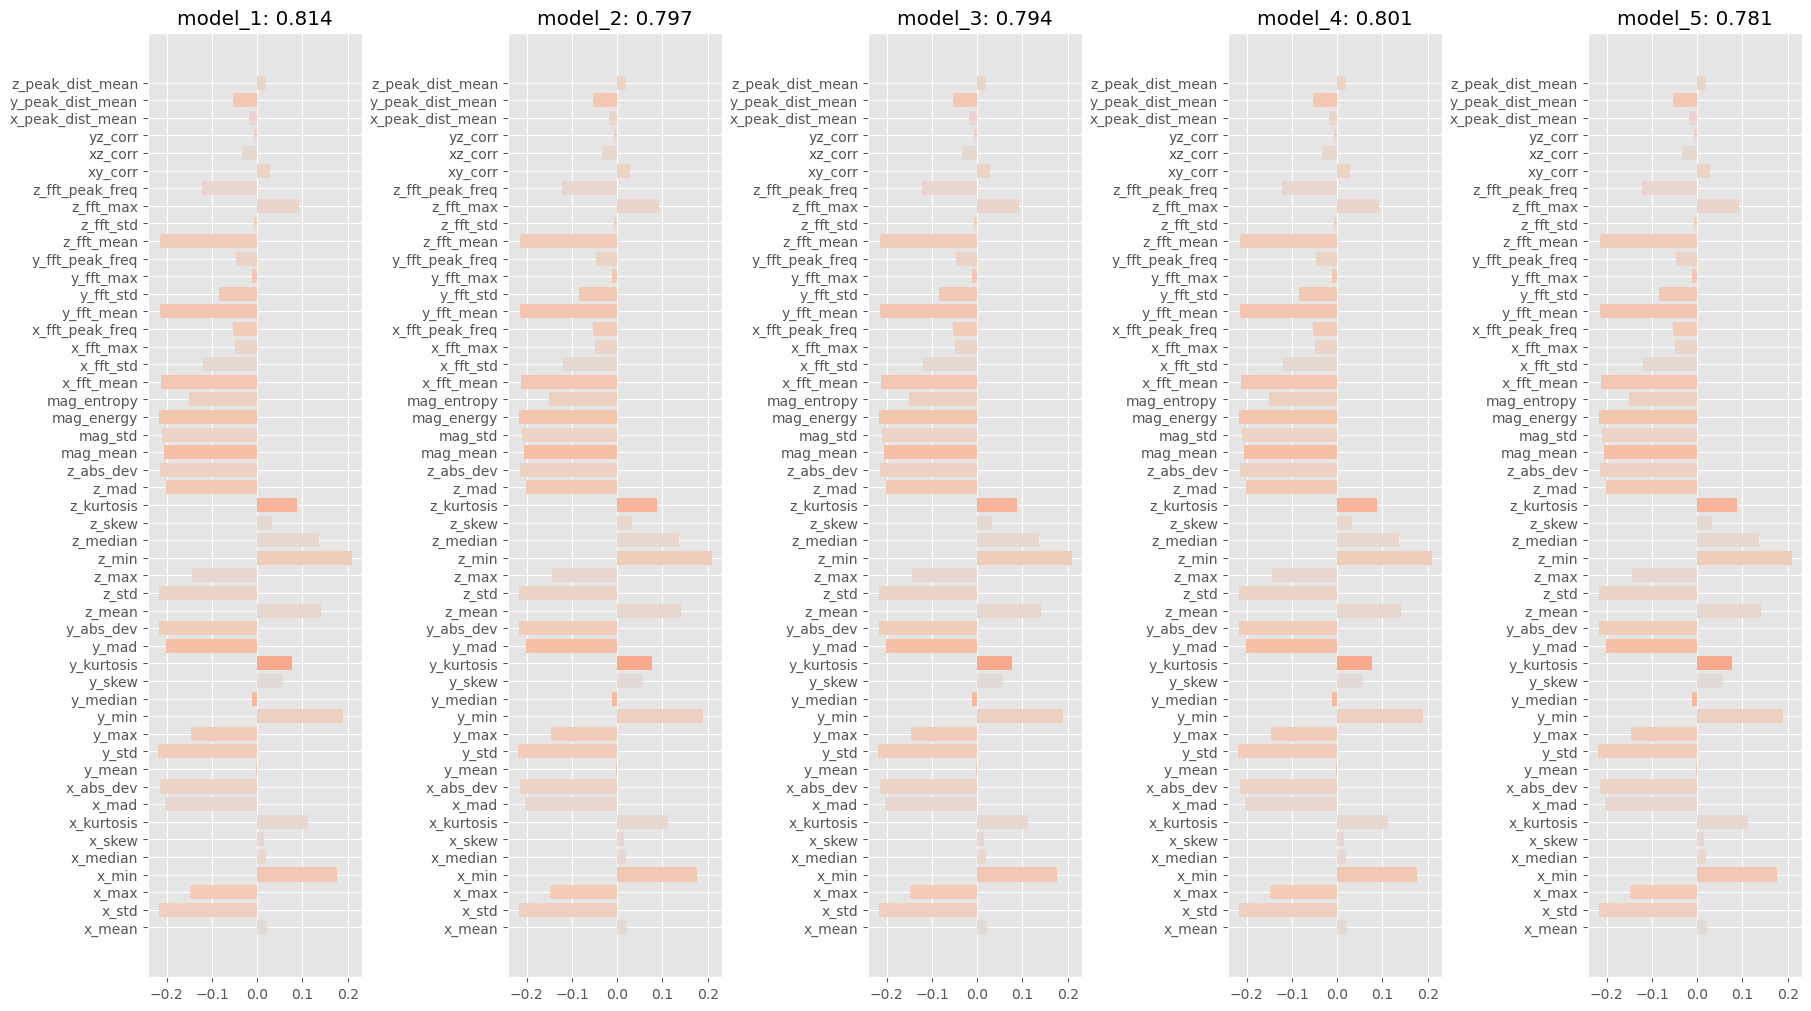

In [133]:
pc_number = 0
all_components = []
for model_no in range(1, 6):
    model_name = f'model_{model_no}'
    model = load_model_config(model_name)
    pipeline = get_pipeline(model)
    pipeline.fit(X_train, y_train)
    pca = pipeline.named_steps['pca']
    components = pca.components_[pc_number]
    all_components.extend(components)

norm = Normalize(vmin=min(all_components), vmax=max(all_components))
cmap = cm.coolwarm

# Plot with consistent coloring
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(18, 10), layout='constrained')
axs = axs.ravel()
all_importances = {}
for model_no, ax in enumerate(axs, start = 1):
    model_name = f'model_{model_no}'
    model = load_model_config(model_name)
    score = model['score']
    pipeline = get_pipeline(model)
    pipeline.fit(X_train, y_train)
    pca = pipeline.named_steps['pca']
    components = pca.components_[pc_number]
    colors = cmap(norm(importances))
    bars = ax.barh(features, components, color=colors)
    ax.set_title(f'{model_name}: {score:.3f}')

# sm = cm.ScalarMappable(cmap=cmap, norm=norm)
# fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label='Feature Importance')
plt.show()

### (Approximate) feature_importance_ by PCA reverse engineered

By utilising the components matrices, we can (approximately) map the "feature importance" back into the *Handcrafted features* for visual analysis.  

This is the most useful visualisation of features & how important they are for the decision trees.

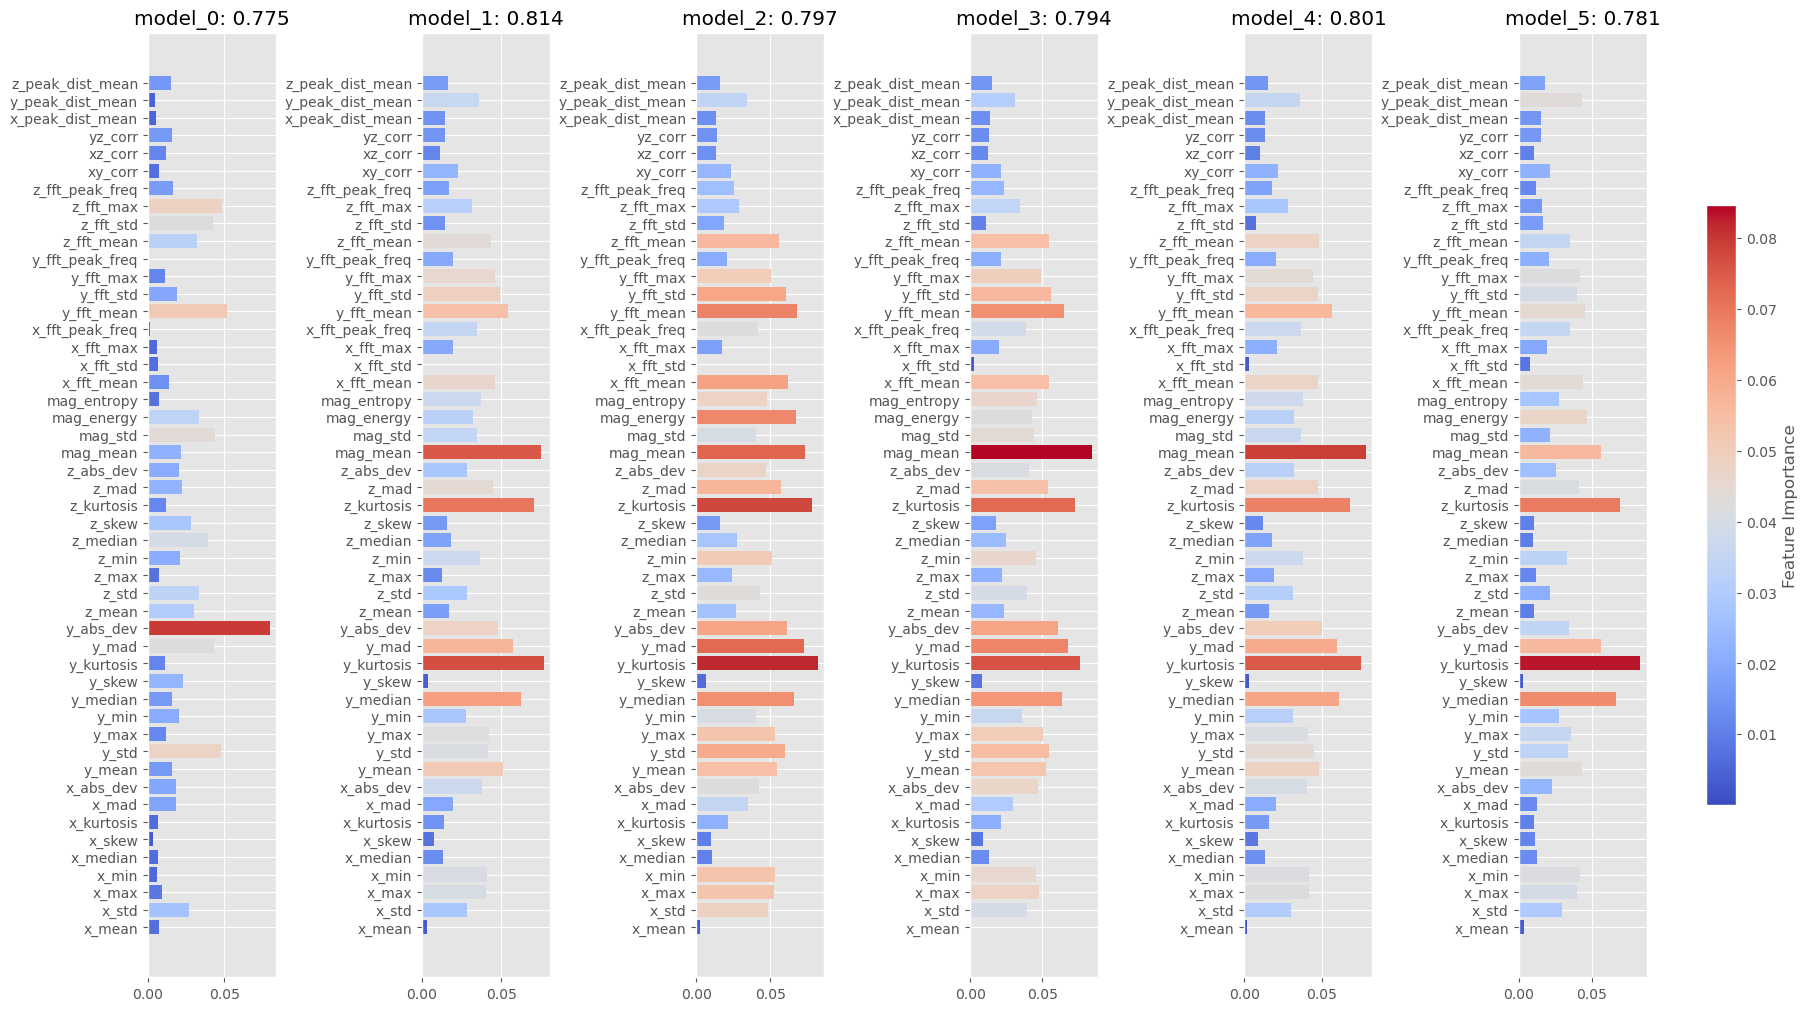

In [132]:
# First, gather all importances to normalize
all_importances = []
for model_no in range(6):
    model_name = f'model_{model_no}'
    model = load_model_config(model_name)
    pipeline = get_pipeline(model)
    pipeline.fit(X_train, y_train)
    rf = pipeline.named_steps['randomforestclassifier']
    try:
        pca = pipeline.named_steps['pca']
        importances = np.abs(pca.components_.T @ rf.feature_importances_)
    except KeyError:
        importances = rf.feature_importances_
    all_importances.extend(importances)

norm = Normalize(vmin=min(all_importances), vmax=max(all_importances))
cmap = cm.coolwarm

# Plot with consistent coloring
fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(18, 10), layout='constrained')
axs = axs.ravel()
all_importances = {}
for model_no, ax in enumerate(axs):
    model_name = f'model_{model_no}'
    model = load_model_config(model_name)
    score = model['score']
    pipeline = get_pipeline(model)
    pipeline.fit(X_train, y_train)
    rf = pipeline.named_steps['randomforestclassifier']
    
    try:
        pca = pipeline.named_steps['pca']
        importances = np.abs(pca.components_.T @ rf.feature_importances_)
    except KeyError:
        importances = rf.feature_importances_
    all_importances[model_name] = importances
    colors = cmap(norm(importances))
    bars = ax.barh(features, importances, color=colors)
    ax.set_title(f'{model_name}: {score:.3f}')

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label='Feature Importance')
plt.show()

## Experiment 3: Feature Removal


#### Option 1: Exclude if 'Feature_importance_' Below Threhsold

$\frac{1}{N_\text{Features}}$ is the value of feature-importance *if every feature is of equal importance*. 

A feature that is *less* important than this threshold is less informative than the average. Equivalently, a *higher* value is a feature that is more informative than the average.

This forms the basis for one criteria of excluding features.

Features to exclude:  ['x_mean', 'x_median', 'x_skew', 'x_kurtosis', 'x_mad', 'y_skew', 'z_mean', 'z_max', 'z_median', 'z_skew', 'x_fft_std', 'x_fft_max', 'z_fft_std', 'z_fft_max', 'z_fft_peak_freq', 'xz_corr', 'yz_corr', 'x_peak_dist_mean', 'z_peak_dist_mean']


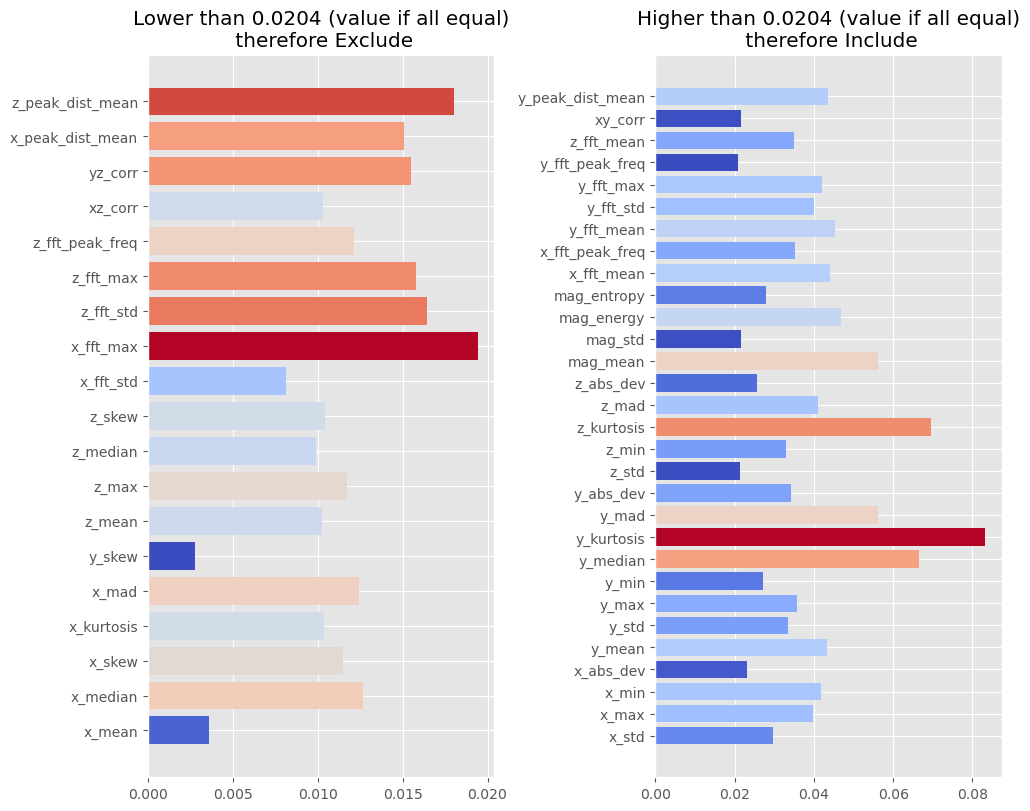

In [36]:
model = load_model_config('model_5', into_pipeline=True)
model.fit(X_train, y_train)
try:
    importances = np.abs(model.named_steps['pca'].components_.T @ model.named_steps['randomforestclassifier'].feature_importances_)
except:
    importances = model.named_steps['randomforestclassifier'].feature_importances_

eq_importance_threshold = 1 / len(features)
under_eq = np.where(importances < eq_importance_threshold)
over_eq = np.where(importances > eq_importance_threshold)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 8), layout = 'constrained')
axs.ravel()
for ax, idxs, title in zip(axs, [under_eq, over_eq], [f'Lower than {eq_importance_threshold:.4f} (value if all equal)\n therefore Exclude', f'Higher than {eq_importance_threshold:.4f} (value if all equal)\n therefore Include']):
    values = importances[idxs]
    feats = features[idxs]

    norm = Normalize(min(values), max(values))
    cmap = cm.coolwarm
    colors = cmap(norm(values))

    ax.barh(feats, values, color= colors)
    ax.set_title(title)
    
print('Features to exclude: ', list(features[under_eq]))
plt.show()

#### Option 2: Exclude beyond Cumulative 'feature_importance_' exceeds 95%

A stricter method to exclude the most uninformative & noisy features.

Features to exclude:  ['z_fft_std', 'x_kurtosis', 'x_median', 'z_max', 'xz_corr', 'x_skew', 'y_skew', 'x_mean', 'x_fft_std']


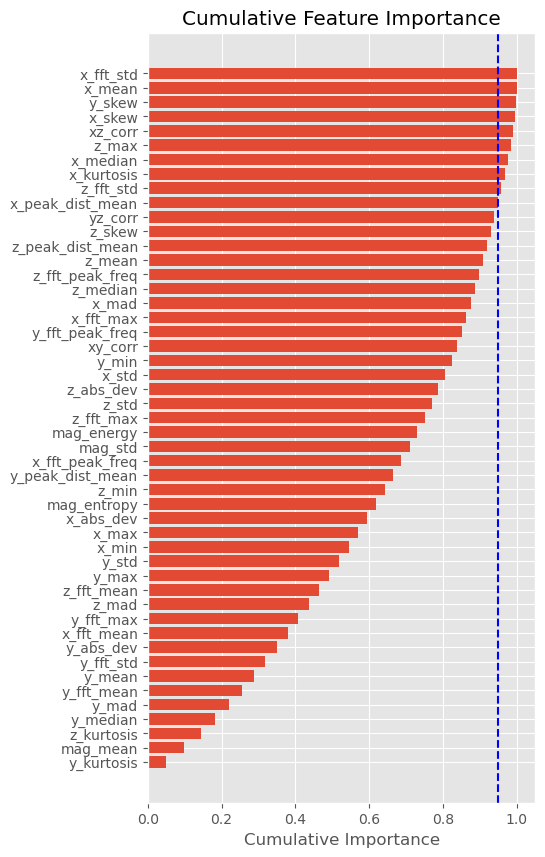

In [207]:
cum_threshold = 0.95

sorted_importances = np.sort(importances)[::-1]
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [features[i] for i in sorted_indices]

cum_importance = np.array([sum(sorted_importances[:i]) for i in range(1, len(importances) + 1)])
cum_importance = cum_importance / cum_importance[-1]

fig, ax = plt.subplots(figsize = (5, 10))

ax.axvline(cum_threshold, color = 'b', linestyle = 'dashed')
ax.barh(sorted_features, cum_importance)
ax.set_xlabel('Cumulative Importance')
ax.set_title('Cumulative Feature Importance')


print('Features to exclude: ', [sorted_features[f] for f in np.argwhere(cum_importance > cum_threshold).T[0]])
plt.show()


### Conclusion?

* Certain features are inactive in multiple models
* certain features are **highly active** in multiple models

In [130]:
train_data_file = '../data/processed/train_feature_clean.csv'
test_data_file = '../data/processed/test_feature_clean.csv'

df_train = pd.read_csv(train_data_file)
df_test = pd.read_csv(test_data_file)

features = df_train.columns[3:]

X_train = df_train[features].values
y_train = df_train['activity']
X_test = df_test[features].values

base_model = load_model_config('model_1.1.2')
base_model_ppl = get_pipeline(base_model)
base_model_ppl.fit(X_train, y_train)

base_importances = np.abs(base_model_ppl.named_steps['pca'].components_.T @ base_model_ppl.named_steps['randomforestclassifier'].feature_importances_)
base_sorted_importances = np.sort(base_importances)[::-1]
base_sorted_indices = np.argsort(base_importances)[::-1]
base_sorted_features = [features[i] for i in base_sorted_indices]

exc_features = {}

stratified_cv = StratifiedKFold(shuffle = True, random_state=6)
for i in range(1, len(features)):
    cols_to_exc = [base_sorted_features[j] for j in range(i)]
    new_features = []
    for f in features:
        if f not in cols_to_exc:
            new_features.append(f)
    X_situation = df_train[new_features].values
    ppl = get_pipeline(base_model)
    results = cross_validate(ppl, X_situation, y_train, cv = stratified_cv, scoring = 'f1_macro')
    exc_features[i] = results

In [137]:
exc_features[1]

{'fit_time': array([2.66577101, 2.75661802, 2.57624602, 2.55108285, 2.51719499]),
 'score_time': array([0.21815681, 0.2323699 , 0.17469311, 0.18914723, 0.21105599]),
 'test_score': array([0.94821795, 0.97383386, 0.96615293, 0.93979488, 0.95861717])}

In [ ]:
a = ["z_fft_std", "x_kurtosis", "x_median", "z_max", "xz_corr", "x_skew", "y_skew", "x_mean", "x_fft_std"]
b = ["y_kurtosis", "mag_mean", "z_kurtosis", "y_median", "y_mad", "y_fft_mean", "y_mean", "y_fft_std", "y_abs_dev", "x_fft_mean"]
c = ["y_kurtosis", "mag_mean", "z_kurtosis", "y_median", "y_mad", "y_fft_mean", "y_mean", "y_fft_std", "y_abs_dev", "x_fft_mean", "y_fft_max", "z_mad", "z_fft_mean", "y_max", "y_std"]

not in c:  z_fft_std
not in c:  x_kurtosis
not in c:  x_median
not in c:  z_max
not in c:  xz_corr
not in c:  x_skew
not in c:  y_skew
not in c:  x_mean
not in c:  x_fft_std
not in a:  y_kurtosis
not in a:  mag_mean
not in a:  z_kurtosis
not in a:  y_median
not in a:  y_mad
not in a:  y_fft_mean
not in a:  y_mean
not in a:  y_fft_std
not in a:  y_abs_dev
not in a:  x_fft_mean
not in a:  y_fft_max
not in a:  z_mad
not in a:  z_fft_mean
not in a:  y_max
not in a:  y_std


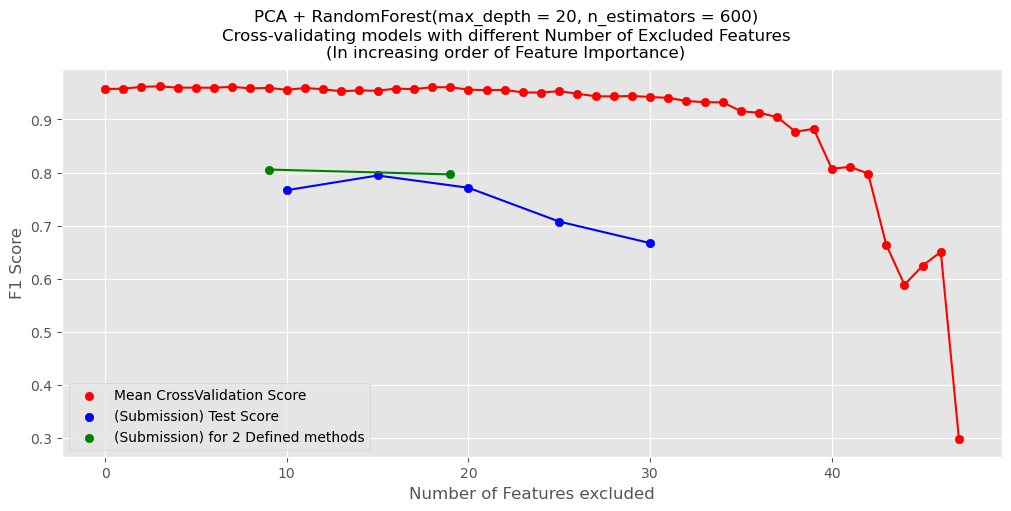

In [182]:
avg_scores = []
avg_fit_times = []
for k, v in exc_features.items():
    avg_scores.append(np.mean(v['test_score']))
    avg_fit_times.append(np.mean(v['fit_time']))

x_score = np.arange(10, 35, 5)
y_score = []
for i in x_score:
    m = load_model_config(f'model_1.1.2_excluding{i}_features')
    n_features_excluded = len(m['excluded_features'])
    y_score.append(m['score'])
    
# fig, axs = plt.subplots(ncols = 2, figsize = (20, 5))
fig, ax = plt.subplots(layout = 'constrained', figsize = (10, 5))

ax.scatter([i for i in range(len(avg_scores))], avg_scores, label = 'Mean CrossValidation Score', color = 'r')
ax.plot([i for i in range(len(avg_scores))], avg_scores, color = 'r')
ax.set_xlabel('Number of Features excluded')
ax.set_ylabel('F1 Score')
ax.scatter(x_score, y_score, label = '(Submission) Test Score', color = 'b')
ax.plot(x_score, y_score, color = 'b')

x = []
y_score = []
for m in ['model_1.1.1', 'model_1.1.2']:
    model = load_model_config(m)
    x.append(len(model['excluded_features']))
    y_score.append(model['score'])

ax.scatter(x, y_score, color = 'g', label = '(Submission) for 2 Defined methods')
ax.plot(x, y_score, color = 'g')


plt.legend()
plt.suptitle('PCA + RandomForest(max_depth = 20, n_estimators = 600)\nCross-validating models with different Number of Excluded Features\n(In increasing order of Feature Importance)')
plt.savefig('figs/feature_exclusion_investigation.png')
plt.show()

In [ ]:
for i in np.arange(10, 35, 5):
    load_model_config(f'model_1.1.2_excluding{i}_features')
    n_features_excluded = []

In [160]:
base_model = load_model_config('model_1.1.2')
base_model_ppl = get_pipeline(base_model)

base_model['excluded_features'] = []
for i in np.arange(10, 35, 5):
    cols_to_exc = [base_sorted_features[j] for j in range(i)]
    save_model_config(base_model_ppl, f'model_1.1.2_excluding{i}_features', excluded_features=cols_to_exc, override=True) 
    # new_features = []
    # for f in features:
    #     if f not in cols_to_exc:
    #         new_features.append(f)
    # X_situation = df_train[new_features].values
    # ppl = get_pipeline(base_model)
    # results = cross_validate(ppl, X_situation, y_train, cv = stratified_cv, scoring = 'f1_macro')
    # exc_features[i] = results
    

In [163]:
for i in np.arange(10, 35, 5):
    save_submission_file(train_data_file=train_data_file, test_data_file = test_data_file, model_name = f'model_1.1.2_excluding{i}_features')

In [127]:
# base_model_ppl.named_steps['pca'].components_
base_model_ppl.named_steps['randomforestclassifier'].feature_importances_.shape

(49,)

In [112]:
sorted_importances

array([7.68138063e-02, 7.52709451e-02, 7.03827454e-02, 6.23077420e-02,
       5.71048583e-02, 5.39933998e-02, 5.11096960e-02, 4.90714964e-02,
       4.77421033e-02, 4.61773724e-02, 4.57820826e-02, 4.47179983e-02,
       4.38034534e-02, 4.20643608e-02, 4.13282905e-02, 4.07698829e-02,
       4.03772942e-02, 3.75426985e-02, 3.69365861e-02, 3.68115384e-02,
       3.59962188e-02, 3.47689617e-02, 3.46442822e-02, 3.21573703e-02,
       3.17417029e-02, 2.86370009e-02, 2.83618950e-02, 2.81617935e-02,
       2.79134172e-02, 2.26413348e-02, 1.96197912e-02, 1.95913738e-02,
       1.94070994e-02, 1.80804657e-02, 1.73147472e-02, 1.72155532e-02,
       1.64135036e-02, 1.57853843e-02, 1.46558147e-02, 1.44671495e-02,
       1.44295820e-02, 1.39524312e-02, 1.32264555e-02, 1.24899756e-02,
       1.13558098e-02, 7.84458510e-03, 3.79716173e-03, 3.22568895e-03,
       8.68992340e-05])

In [113]:
sorted_features

['y_kurtosis',
 'mag_mean',
 'z_kurtosis',
 'y_median',
 'y_mad',
 'y_fft_mean',
 'y_mean',
 'y_fft_std',
 'y_abs_dev',
 'x_fft_mean',
 'y_fft_max',
 'z_mad',
 'z_fft_mean',
 'y_max',
 'y_std',
 'x_min',
 'x_max',
 'x_abs_dev',
 'mag_entropy',
 'z_min',
 'y_peak_dist_mean',
 'x_fft_peak_freq',
 'mag_std',
 'mag_energy',
 'z_fft_max',
 'z_std',
 'z_abs_dev',
 'x_std',
 'y_min',
 'xy_corr',
 'y_fft_peak_freq',
 'x_fft_max',
 'x_mad',
 'z_median',
 'z_fft_peak_freq',
 'z_mean',
 'z_peak_dist_mean',
 'z_skew',
 'yz_corr',
 'x_peak_dist_mean',
 'z_fft_std',
 'x_kurtosis',
 'x_median',
 'z_max',
 'xz_corr',
 'x_skew',
 'y_skew',
 'x_mean',
 'x_fft_std']

In [ ]:
importances = np.abs(ppl.named_steps['pca'].components_.T @ ppl.named_steps['randomforestclassifier'].feature_importances_)

### Confusion Matrix
For validating models, I've relied less on using the `train_test_split` method, since cross-validation methods are more reliable for testing across different splits of the training-data.

However, for a visual analysis, confusion matrices are often useful too.

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       166
           1       0.97      0.98      0.98       624
           2       1.00      0.98      0.99       117
           3       0.98      1.00      0.99        88
           4       0.96      0.84      0.90       228
           5       0.95      1.00      0.97       709

    accuracy                           0.96      1932
   macro avg       0.97      0.95      0.96      1932
weighted avg       0.96      0.96      0.96      1932

F1: 0.9573755933144711


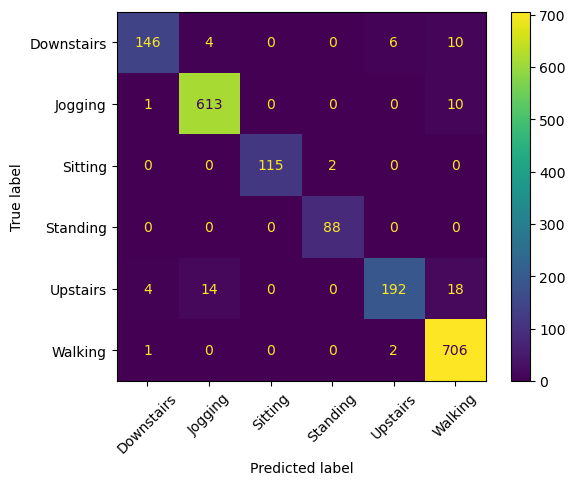

Cross-validation Accuracy: [0.96195652 0.97360248 0.97981366 0.96195652 0.96814297]
Cross-validation F1 scores: [0.95203093 0.96801903 0.97598919 0.94815199 0.95579761]
Mean Accuracy: 0.9690944321379102
Mean F1 score: 0.9599977516129776


In [74]:
model = load_model_config('model_1', into_pipeline=True)
test_size = 0.3

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=test_size, random_state=MY_SEED)

model.fit(X_train_split, y_train_split)
y_val_pred = model.predict(X_val_split)


print(classification_report(y_val_split, y_val_pred))
print("F1:", f1_score(y_val_split, y_val_pred, average= 'macro'))


plt.style.use('default')
conf_matrix = confusion_matrix(y_val_split, y_val_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=LABELS).plot(xticks_rotation=45)
plt.show()
plt.style.use('ggplot')

## Results

Testing the parameter sets, I found that generally:
* $\uparrow$ **n_estimators** $\implies\uparrow$ **Fit Time** & $\uparrow$**Validation Score** (More Generalizable up to a point; **However**, There is an upper limit, after which it overfits)
* $\uparrow$ **max_depth** $\implies\uparrow$ **Fit Time** & $\downarrow$ **Validation Score** (Overfitting!)
* $\uparrow$ **max_features**$\implies\uparrow$ **Fit Time** & $\downarrow$ **Validation Score** (Overfitting!)

## Experiment 4.1: Undersampling from Majority Classes (Model 6 & 6.5)

Post-Hoc analysis of model predictions & performances (see below) suggest potential mistreatment of class-distributions.

RandomForestClassifier's `class_weight = "balanced"` takes place at calculating the loss function, but potentially the bootstrapped sample is already over-representing majority classes ('walking'/'jogging'). 

model_6 aims to incorporate this fact by **undersampling** from these majority classes. Again, using a GridSearchCV (Small param set) for finding optimal parameters on this pipeline step

model 6.5 uses fewer trees (for comparison)


In [ ]:
model_1_1_2 = load_model_config('model_1.1.2')


X_train, y_train, X_test, features = get_training_splits(model_1_1_2, train_data_file, test_data_file) # we've reduced the feature-set 

model_1_1_2.fit(X_train, y_train)
model_1_1_2.predict(y_train)



model_1_1_2 = load_model_config('model_1.1.2')
model_1_1_2['steps']['randomforestclassifier']['class_weight'] = None

In [73]:

model_1_1_2 = load_model_config('model_1.1.2')

X_train, y_train, X_test, features = get_training_splits(model_1_1_2, train_data_file, test_data_file) # we've reduced the feature-set 

X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=MY_SEED, stratify=y_train
)

pipeline = get_pipeline(model_1_1_2)
pipeline.fit(X_fit, y_fit)
y_val_pred =pipeline.predict(X_val)
print(classification_report(y_val, y_val_pred, digits = 4))

model_1_1_2 = load_model_config('model_1.1.2')
model_1_1_2['steps']['randomforestclassifier']['class_weight'] = None
undersampled_pipeline = make_imb_pipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=MY_SEED,  ),
    PCA(random_state=MY_SEED),
    RandomForestClassifier(**model['steps']['randomforestclassifier'])
)
param_dist = {
    'randomundersampler__replacement': [True, False],
    'randomforestclassifier__class_weight': [None, 'balanced'],
}


param_search = GridSearchCV(estimator = undersampled_pipeline,
                         param_grid=param_dist,
                         cv = stratified_cv,
                         scoring = ['f1_macro', 'recall_macro', 'precision_macro'],
                         n_jobs=-1, 
                         refit = 'f1_macro')

param_search.fit(X_train, y_train)

[print(f'{score}: ', param_search.cv_results_[f'mean_test_{score}'], np.argmax(param_search.cv_results_[f'mean_test_{score}'])) for score in ['f1_macro', 'recall_macro', 'precision_macro']]
print('Best Choice: ', param_search.best_params_)

X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=MY_SEED, stratify=y_train
)

best_model = param_search.best_estimator_
best_model.fit(X_fit, y_fit)

y_val_pred = best_model.predict(X_val)
print(classification_report(y_val, y_val_pred, digits = 4))

save_model_config(best_model, 'model_6', notes = "Altering the model_1.1.2 structure; including an undersampling stage instead of class_weight = 'balanced'",  excluded_features = model_1_1_2['excluded_features'])

              precision    recall  f1-score   support

  Downstairs     0.9720    0.8889    0.9286       117
     Jogging     0.9760    0.9951    0.9855       409
     Sitting     0.9873    0.9873    0.9873        79
    Standing     0.9833    1.0000    0.9916        59
    Upstairs     0.9485    0.8958    0.9214       144
     Walking     0.9775    0.9958    0.9866       480

    accuracy                         0.9744      1288
   macro avg     0.9741    0.9605    0.9668      1288
weighted avg     0.9742    0.9744    0.9740      1288

f1_macro:  [0.93465815 0.93926037 0.93465815 0.93926037] 1
recall_macro:  [0.93839536 0.94583779 0.93839536 0.94583779] 1
precision_macro:  [0.93154878 0.93451589 0.93154878 0.93451589] 1
Best Choice:  {'randomforestclassifier__class_weight': None, 'randomundersampler__replacement': False}
              precision    recall  f1-score   support

  Downstairs     0.9106    0.9573    0.9333       117
     Jogging     0.9690    0.9927    0.9807       409
   

## Experiment 4.2: Oversampling From Minority Classes (Model 7 & 7.5)
Comparing to above methods, I also test performance of using **Oversampling** from minority class methods.

Model 7.5 uses fewer trees for comparison.

In [83]:
model_1_1_2 = load_model_config('model_1.1.2')

X_train, y_train, X_test, features = get_training_splits(model_1_1_2, train_data_file, test_data_file) # we've reduced the feature-set 

X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=MY_SEED, stratify=y_train
)

pipeline = get_pipeline(model_1_1_2)
pipeline.fit(X_fit, y_fit)
y_val_pred =pipeline.predict(X_val)
print(classification_report(y_val, y_val_pred, digits = 4))

model_1_1_2 = load_model_config('model_1.1.2')
model_1_1_2['steps']['randomforestclassifier']['class_weight'] = None
undersampled_pipeline = make_imb_pipeline(
    StandardScaler(),
    SMOTE(random_state=MY_SEED),
    PCA(random_state=MY_SEED),
    RandomForestClassifier(**model['steps']['randomforestclassifier'])
)
param_dist = {
    'smote__k_neighbors': [3, 4, 5, 6, 7],
}

param_search = GridSearchCV(estimator = undersampled_pipeline,
                         param_grid=param_dist,
                         cv = stratified_cv,
                         scoring = ['f1_macro', 'recall_macro', 'precision_macro'],
                         n_jobs=-1, 
                         refit = 'f1_macro')

param_search.fit(X_train, y_train)

[print(f'{score}: ', param_search.cv_results_[f'mean_test_{score}'], np.argmax(param_search.cv_results_[f'mean_test_{score}'])) for score in ['f1_macro', 'recall_macro', 'precision_macro']]
print('Best Choice: ', param_search.best_params_)

X_fit, X_val, y_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=MY_SEED, stratify=y_train
)

best_model = param_search.best_estimator_
best_model.fit(X_fit, y_fit)

y_val_pred = best_model.predict(X_val)
print(classification_report(y_val, y_val_pred, digits = 4))

# save_model_config(best_model, 'model_7', notes = "Altering the model_1.1.2 structure; including an SMOTE oveersampling stage instead of class_weight = 'balanced'",  excluded_features = model_1_1_2['excluded_features'])

              precision    recall  f1-score   support

  Downstairs     0.9720    0.8889    0.9286       117
     Jogging     0.9760    0.9951    0.9855       409
     Sitting     0.9873    0.9873    0.9873        79
    Standing     0.9833    1.0000    0.9916        59
    Upstairs     0.9485    0.8958    0.9214       144
     Walking     0.9775    0.9958    0.9866       480

    accuracy                         0.9744      1288
   macro avg     0.9741    0.9605    0.9668      1288
weighted avg     0.9742    0.9744    0.9740      1288

f1_macro:  [0.96926023 0.97202221 0.96622235 0.96691681 0.96704734] 1
recall_macro:  [0.96800135 0.97107872 0.96555169 0.96596522 0.96650769] 1
precision_macro:  [0.97090097 0.97326199 0.96730717 0.96814937 0.96792282] 1
Best Choice:  {'smote__k_neighbors': 4}
              precision    recall  f1-score   support

  Downstairs     0.9474    0.9231    0.9351       117
     Jogging     0.9831    0.9927    0.9878       409
     Sitting     1.0000    0.9747

In [ ]:
ppline = load_model_config('model_6', into_pipeline=True)

In [ ]:
steps = ppline['steps']
ppl_steps = []
for k, v in steps.items():
    s = STEP_CLASS_MAP[k]
    ppl_steps.append(s(**v))
ppl = make_imb_pipeline(*ppl_steps)

In [85]:
save_model_config(best_model, 'model_7', notes = "1.1.2 using SMOTE", excluded_features = model_1_1_2['excluded_features'])

# Submission
The final submission of predictions by a model is produced here.

After fitting & predicting, the `predictions_allzero.csv` file (produced in **preprocessing**; contains all rows from `test_feature.csv` that are problematic/empty) is attached afterwards.

In [8]:
save_submission_file(
 train_data_file=train_data_file,
 test_data_file = test_data_file, 
 model_name = 'model_7.5',
#  as_filename='model_1_new.csv'
)

# Post-Hoc Analysis

## Investigating Class Distributions

As a result of losing the model configuration for model_1 (0.81372), I compare the class distributions of predictions produced by its best approximation (the newly kept & *properly maintained* model_1 config).

As an Extension to this, I compare the newly best performing model (model_1.1.2: 0.80559), and the training_data, to get a picture of how each model distributes predictions.

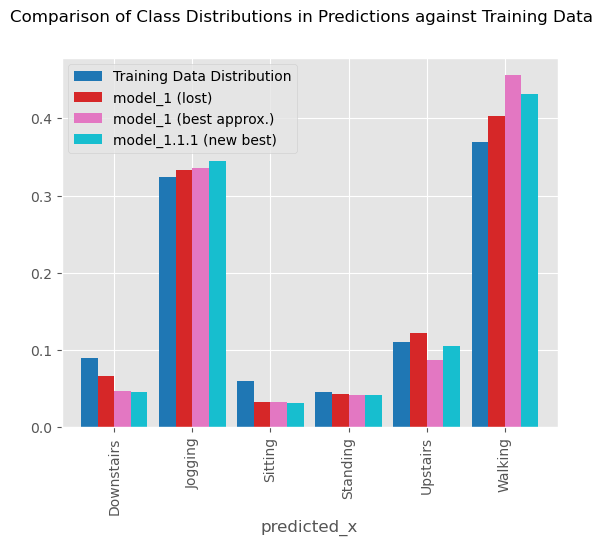

In [78]:
model1= pd.read_csv('predictions/Feature/feature_model_1_BEST.csv')
model1new = pd.read_csv('predictions/Feature/model_1_new.csv')
model1_1_2 = pd.read_csv('predictions/Feature/model_1.1.2_retry.csv')

df_compare = pd.merge(model1, model1new, how = 'outer', left_on='id', right_on='id')
df_compare = pd.merge(df_compare, model1_1_2, how = 'outer', left_on='id', right_on='id')

ser1 = df_compare.groupby('predicted_x').size()/len(df_compare)
ser2 = df_compare.groupby('predicted_y').size()/len(df_compare)
ser3 = df_train.groupby('activity').size()
ser4 = df_compare.groupby('predicted').size()/len(df_compare)
ser3['Jogging'] += 68
ser3['Upstairs'] += 2
ser3 = ser3/sum(ser3)
df_compare_counts = pd.DataFrame(data = {'Training Data Distribution': ser3, 'model_1 (lost)': ser1, 'model_1 (best approx.)': ser2, 'model_1.1.1 (new best)': ser4}, index = ser1.index)

fig, ax = plt.subplots()
df_compare_counts.plot(kind = 'bar', ax = ax, width = 0.85, colormap = 'tab10')
plt.suptitle('Comparison of Class Distributions in Predictions against Training Data')
plt.show()

### Comments
The training data exhibits strong majorities in the 'Jogging' and "Walking" activites, but **the produced models are overestimating these majority classes** in comparison.

Potentially, this is a sampling (bootstrapping) & overfitting issue.

**Model_1.1.2** is *closer* with walking, suggesting that it's reduced input features are more generalized around noisy features. 

In [48]:
model = load_model_config('model_1.1.2')

X_train, y_train, X_test, features = get_training_splits(model, train_data_file, test_data_file)

pipeline = get_pipeline(model)

new_model = model.copy()
new_model['steps']['randomforestclassifier']['class_weight'] = None

new_pipeline = get_pipeline(new_model)

baseline_validation = cross_validate(pipeline,  X_train, y_train, cv =stratified_cv, scoring = 'f1_macro', return_train_score=False)
new_validation = cross_validate(new_pipeline, X_train, y_train, cv =stratified_cv, scoring = 'f1_macro', return_train_score=False)

print(f"Cross-validation F1 scores: Base = {baseline_validation['test_score']} \nNew = {new_validation['test_score']}")
print(f"Mean F1 score: Base = {np.mean(baseline_validation['test_score'])} | New = {np.mean(new_validation['test_score'])}")

Cross-validation F1 scores: Base = [0.94140788 0.97274103 0.96677648 0.96399088 0.96187103] 
New = [0.95155542 0.97215272 0.96345889 0.963626   0.96136823]
Mean F1 score: Base = 0.9613574574712693 | New = 0.9624322503778208
